In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
#Load the Data
test_directory = r"C:\Users\lenovo\OneDrive\Documents\Lungs\Class_D\test"
train_directory = r"C:\Users\lenovo\OneDrive\Documents\Lungs\Class_D\train"

# Define the image data generator
data_generator = ImageDataGenerator(rescale=1./255)  # You can add more augmentation settings if needed

# Set the batch size and image dimensions
batch_size = 32
image_size = (256, 256)

# Load the data
train_data = data_generator.flow_from_directory(
    directory=train_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # If you have categorical labels
    seed=42
)

test_data = data_generator.flow_from_directory(
    directory=test_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    seed=42
)


Found 876 images belonging to 3 classes.
Found 221 images belonging to 3 classes.


In [3]:
test_data.class_indices

{'Bengin cases': 0, 'Malignant cases': 1, 'Normal cases': 2}

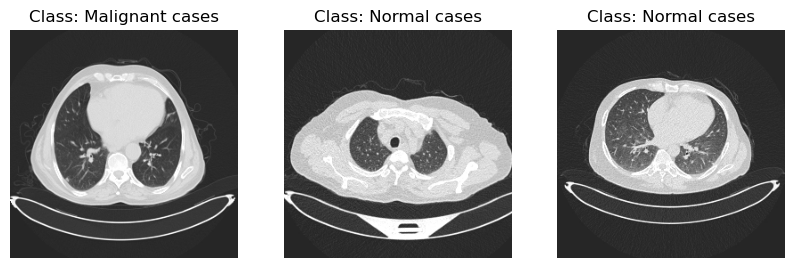

In [4]:
import matplotlib.pyplot as plt

# Get a batch of data from the train data generator
batch = next(train_data)

# Extract images and labels from the batch
images = batch[0][:3]  # Select the first three images
labels = batch[1][:3]  # Select the corresponding labels

# Get class labels
class_labels = train_data.class_indices
class_names = list(class_labels.keys())

# Display the images along with their labels
plt.figure(figsize=(10, 10))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i])
    plt.title("Class: " + class_names[labels[i].argmax()])
    plt.axis('off')
plt.show()


## CNN

In [5]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])


model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_data, epochs=7, validation_data=test_data)


loss, accuracy = model.evaluate(test_data)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/7
28/28 [==============================] - 80s 3s/step - loss: 1.3116 - accuracy: 0.5160 - val_loss: 0.8599 - val_accuracy: 0.6063
Epoch 2/7
28/28 [==============================] - 71s 3s/step - loss: 0.6835 - accuracy: 0.7089 - val_loss: 0.5678 - val_accuracy: 0.7964
Epoch 3/7
28/28 [==============================] - 61s 2s/step - loss: 0.3860 - accuracy: 0.8470 - val_loss: 0.2786 - val_accuracy: 0.8824
Epoch 4/7
28/28 [==============================] - 59s 2s/step - loss: 0.2396 - accuracy: 0.9132 - val_loss: 0.1744 - val_accuracy: 0.9367
Epoch 5/7
28/28 [==============================] - 62s 2s/step - loss: 0.1404 - accuracy: 0.9566 - val_loss: 0.1267 - val_accuracy: 0.9593
Epoch 6/7
28/28 [==============================] - 84s 3s/step - loss: 0.1256 - accuracy: 0.9578 - val_loss: 0.0958 - val_accuracy: 0.9638
Epoch 7/7
7/7 [==============================] - 4s 577ms/step - loss: 0.0918 - accuracy: 0.9774
Test Loss: 0.09175503998994827
Test Accuracy: 0.9773755669593811


In [ ]:
y_pred = model.predict(test_data)
y_true = test_data.classes
conf_matrix = confusion_matrix(y_true, y_pred.argmax(axis=1))
print(conf_matrix)

7/7 [==============================] - 3s 421ms/step
[[ 3 12  9]
 [ 8 51 54]
 [ 9 48 27]]


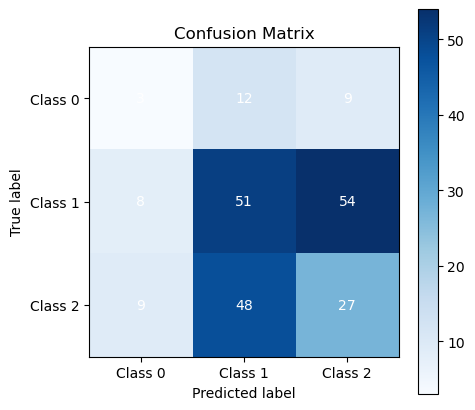

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        plt.text(j, i, str(conf_matrix[i][j]), ha='center', va='center', color='white')

plt.xticks(range(3), ["Class 0", "Class 1", "Class 2"])
plt.yticks(range(3), ["Class 0", "Class 1", "Class 2"])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


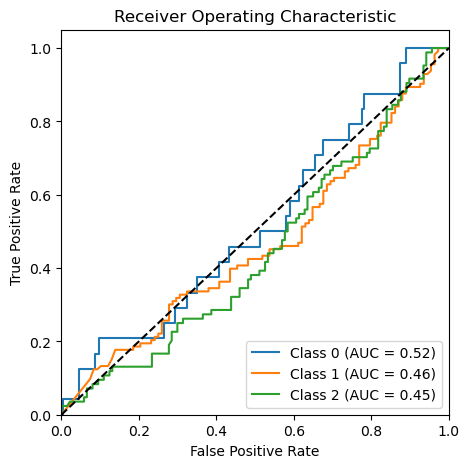

In [ ]:
plt.figure(figsize=(5, 5))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## VGG19

In [1]:
from __future__ import print_function

import numpy as np
import warnings

from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input

In [2]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras
import tensorflow

from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, Activation

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Set the path to your train and test data folders
train_data_dir = r'/content/Class_D/train'
test_data_dir = r"/content/Class_D/test"

# Define the input size and batch size
input_size = (32, 32)
batch_size = 32

# Create an instance of the ImageDataGenerator for train and test data
datagen = ImageDataGenerator(rescale=1./255)

# Load the train data from the train folder
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',  # Set the class mode based on your labels
    shuffle=False  # Set shuffle to False to maintain order
)

# Load the test data from the test folder
test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',  # Set the class mode based on your labels
    shuffle=False  # Set shuffle to False to maintain order
)

# Extract the images and labels from the generators
x_train, y_train = train_generator.next()
x_test, y_test = test_generator.next()

# Convert labels to integers if necessary
y_train = np.asarray(y_train, dtype=int)
y_test = np.asarray(y_test, dtype=int)

Found 876 images belonging to 3 classes.
Found 221 images belonging to 3 classes.


In [13]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the VGG19 model with pre-trained weights
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom fully connected layers on top of the VGG19 base
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
output = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)
model.summary()

# Compile the model with appropriate optimizer and loss for multi-class classification
optimizer = SGD(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Set up data generators for image preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    # other augmentation parameters...
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255
)

# Create data generators for training and validation data
train_generator = train_datagen.flow_from_directory(
    '/content/Class_D/train',
    target_size=(224, 224),  # Resize images to (224, 224)
    batch_size=8,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/Class_D/test',
    target_size=(224, 224),  # Resize images to (224, 224)
    batch_size=8,
    class_mode='categorical'
)

# Fit the model using the generators
history = model.fit(train_generator, validation_data=test_generator, epochs=100)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

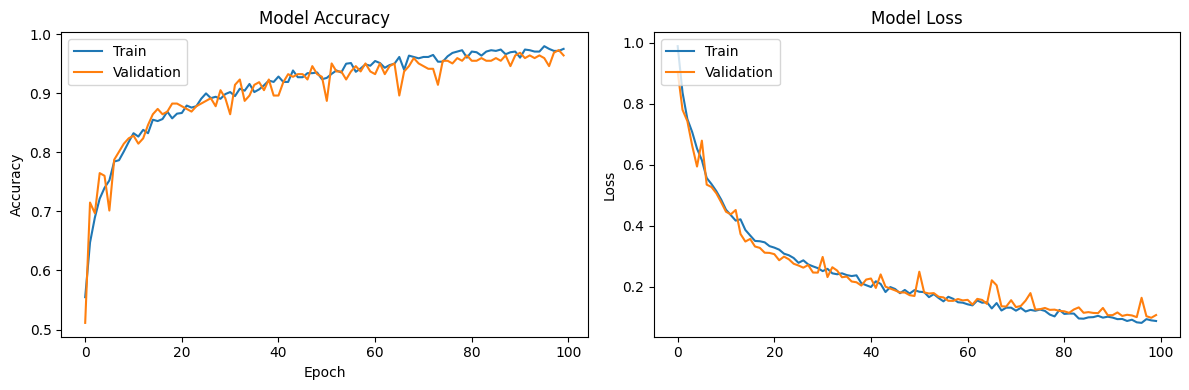

In [14]:
import matplotlib.pyplot as plt
# Visualize training progress
plt.figure(figsize=(12, 4))
# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()
